# Fun with Phyllids!!
## Bryophyte and Lycophyte lateral organs

__________

The following is a `jupyter notebook` ([Kluyver et al. 2016](https://ebooks.iospress.nl/doi/10.3233/978-1-61499-649-1-87)) tutorial written using the `python` coding language. Text written in `markdown cells` is used to explain code presented and executed in `coding cells`. This tutorial assumes a working knowledge of `python` and the ability to use `jupyter notebooks`.  

If you are new to `python` or do not know how to use `jupyter notebooks`, we recommend that you familiarize yourself with them through a tutorial. For the context of plant biology and leaf shape presented here, we recommend `Plants&Python` ([VanBuren et al., 2022](https://doi.org/10.1093/plcell/koac187)), accessible using this [link](https://plantsandpython.github.io/PlantsAndPython). There you will find instructions for downloading and installing [Anaconda](https://docs.anaconda.com/anaconda/install/) and how to get going with `jupyter notebooks` and `python`.

### Import modules

We first import modules which contain functions and other code necessary to perform the analysis in this `jupyter notebook`.

Below, we provide references for some of the modules used in this notebook:  

- `pandas`, [McKinney, 2010](http://conference.scipy.org.s3.amazonaws.com/proceedings/scipy2010/pdfs/mckinney.pdf)
- `numpy`, [Harris et al., 2020](https://www.nature.com/articles/s41586-020-2649-2)
- `matplotlib`, [Hunter, 2007](https://www.computer.org/csdl/magazine/cs/2007/03/c3090/13rRUwbJD0A)
- `scikit-learn`, [Pedregosa et al., 2011](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf?ref=https:/)
- `scipy`, [Virtanen et al., 2020](https://www.nature.com/articles/s41592-019-0686-2)
- `seaborn`, [Waskom, 2021](https://joss.theoj.org/papers/10.21105/joss.03021.pdf)
- `OpenCV`, [Bradski and Kaehler, 2008](https://www.google.com/books/edition/Learning_OpenCV/seAgiOfu2EIC?hl=en&gbpv=0)

In [1]:
#######################
### LOAD IN MODULES ###
#######################

import cv2 # to install on mac: pip install opencv-python
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
from scipy.spatial import procrustes # for Procrustes analysis
from scipy.spatial import ConvexHull # for convex hull
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import matplotlib.pyplot as plt # for plotting
import numpy as np # for using arrays
import math # for mathematical operations
import pandas as pd # for using pandas dataframes
import seaborn as sns # for plotting in seaborn
from matplotlib.colors import LogNorm

### Define functions

The following functions define useful operations used in the analysis.

In [2]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean


_________
### Lateral organ data
__________

We will analyze 126 outlines of phyllids and microphylls from bryophytes and lycophytes. The data was collected by [Pablo Sebastian Milla Carmona](https://orcid.org/0000-0002-0396-6244) (University of Bristol, UK). The data is in the folder `lyco_bryo_shapes`.

Each leaf contains 200 `x` and `y` coordinate values.
1. The first coordinate (**index 0**) is the base.
2. The 101st coordinate (**index 100**) is the tip.

### Read in data

In [3]:
#######################################
### MAKE A LIST OF IMAGE FILE NAMES ###
#######################################

data_dir = "./lyco_bryo_shapes/" # set data directory

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

#file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

file_names # check list of file names

['Barbula_indica_5.txt',
 'Brachymenium_elimbatum_1Dcenter.txt',
 'Brachymenium_elimbatum_1Dleft.txt',
 'Brachymenium_elimbatum_1Dright.txt',
 'Brachymenium_sublineare_2Dcenter.txt',
 'Brachymenium_sublineare_2Dleft.txt',
 'Brachymenium_sublineare_2Dright.txt',
 'Bryocrumia_vivicolor_2Cleft.txt',
 'Bryocrumia_vivicolor_2Dcenterright.txt',
 'Bryocrumia_vivicolor_2Dleft.txt',
 'Bryocrumia_vivicolor_2Dright.txt',
 'Bryum_limbatum_6.txt',
 'Campylopus_carolinae_8.txt',
 'Cladastomum_ulei_5f.txt',
 'Donnellia_commutata_3B.txt',
 'Entodon_hampeanus_3F.txt',
 'Entodontopsis_pygmaea_2afirst.txt',
 'Entodontopsis_pygmaea_2asecond.txt',
 'Entodontopsis_pygmaea_2athird.txt',
 'Henicodium_geniculatum_3H.txt',
 'Herpetineuron_toccoae_3J.txt',
 'Huperzia_asiatica_Limetal2015-1.txt',
 'Huperzia_asiatica_Limetal2015-2.txt',
 'Huperzia_javanica_Limetal2015-3.txt',
 'Huperzia_javanica_Limetal2015-4.txt',
 'Huperzia_jejuensis_Lim&Sun-1.txt',
 'Huperzia_jejuensis_Lim&Sun-2.txt',
 'Hyophila_involuta_4.1.tx

### Process and landmark data

- Read in outline
- Get tip and base indices
- Interpolate with a high resolution of pseudo-landmarks
- Reset the base index to zero
- Interpolate each side with desired number of equidistant pseudo-landmarks
- Rotate leaves upright
- Save pseudo-landmarks to an array

PARAMETERS AND INDEXING:
- `high_res_pts` is an arbitrarily high number of points to initially interpolate
- `res` is the desired number of points to interpolate on each side of the leaf
- The total number of pseudo-landmarks will be `2*res - 1`
- The base index will be `0`
- The tip index will be `res-1`
- The returned leaves are in `land_arr` 

In [4]:
######################
### SET PARAMETERS ###
######################

# the number of equidistant points to create
# an initial high resolution outline of the leaf
high_res_pts = 10000

# the ultimate number of equidistant points on each side of the leaf
# (-1 for the index of the tip)
# the leaf will have res*2-1 pseudo-landmarks
#################
#################
#################
res = 50 ########
#################
#################

# an array to store pseudo-landmarks
# the number of leaves x the number of pseudo-landmarks x 2 coordinates
land_arr = np.zeros((len(file_names),(res*2)-1,2))

for i in range(len(file_names)): # for each leaf
    
    #############################################
    ### READ IN DATA AND RETRIEVE INFORMATION ###
    #############################################

    name = file_names[i] # get current file name
    
    print(i, name) # print current file name for trouble shooting

    lf_coords = np.loadtxt(data_dir + name) # load in leaf coordinates
    
    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaf to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(lf_coords[:,0], 
                                           lf_coords[:,1], high_res_pts)

    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    # get the base and tip landmark point values
    base_pt = lf_coords[0,:] # base = index 0
    tip_pt = lf_coords[100,:] # tip = index 100

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)
    
    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaf coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))
    
    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaf
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))
    
    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))
    
    # store the leaf scaled into cm into the land_arr
    land_arr[i,:,:] = rot_pts


0 Barbula_indica_5.txt
1 Brachymenium_elimbatum_1Dcenter.txt
2 Brachymenium_elimbatum_1Dleft.txt
3 Brachymenium_elimbatum_1Dright.txt
4 Brachymenium_sublineare_2Dcenter.txt
5 Brachymenium_sublineare_2Dleft.txt
6 Brachymenium_sublineare_2Dright.txt
7 Bryocrumia_vivicolor_2Cleft.txt
8 Bryocrumia_vivicolor_2Dcenterright.txt
9 Bryocrumia_vivicolor_2Dleft.txt
10 Bryocrumia_vivicolor_2Dright.txt
11 Bryum_limbatum_6.txt
12 Campylopus_carolinae_8.txt
13 Cladastomum_ulei_5f.txt
14 Donnellia_commutata_3B.txt
15 Entodon_hampeanus_3F.txt
16 Entodontopsis_pygmaea_2afirst.txt
17 Entodontopsis_pygmaea_2asecond.txt
18 Entodontopsis_pygmaea_2athird.txt
19 Henicodium_geniculatum_3H.txt
20 Herpetineuron_toccoae_3J.txt
21 Huperzia_asiatica_Limetal2015-1.txt
22 Huperzia_asiatica_Limetal2015-2.txt
23 Huperzia_javanica_Limetal2015-3.txt
24 Huperzia_javanica_Limetal2015-4.txt
25 Huperzia_jejuensis_Lim&Sun-1.txt
26 Huperzia_jejuensis_Lim&Sun-2.txt
27 Hyophila_involuta_4.1.txt
28 Hyophila_involuta_4.2.txt
29 Hy

Leaf shape data from cultivated varieties includes four types from 16 varieties. Except for Amazona, for which 19 leaves were measured, 20 leaves were measured for all other varieties, resulting in 319 cultivated leaves that were analyzed. From Ipadu types the varieties include Amazona, Boliviana Blanca, Gigante, and Trujillense Caucana; from Coca types the varieties include Bolivana Rojo, Chiparra, Chirosa, Dulce, Guayaba Roja, Patirroja, Peruana Roja, Tingo Maria, and Tingo Peruana; from Truxillense types the varieties include Crespa; and from Novogranatense types the varieties include Tingo Pajarita and Tingo Pajarita Caucana. Leaf shape data was saved as binary image files with pixels per centimeter scale information for each leaf and estimated base and tip landmark data that was manually placed using FIJI ([Schindelin et al., 2012](https://www.nature.com/articles/nmeth.2019)).

### Check leaves by plotting them out

Let us first assign if the lateral organs are moss or lycophyte.

In [5]:
types = [] # a list to store leaf types

for i in range(len(file_names)): # for each leaf
    curr_name = file_names[i] # get current name

    # assign type
    if "Barbula" in curr_name:
        types.append("moss")
    elif "Brachymenium" in curr_name:
        types.append("moss")
    elif "Bryocrumia" in curr_name:
        types.append("moss")
    elif "Bryum" in curr_name:
        types.append("moss")
    elif "Campylopus" in curr_name:
        types.append("moss")
    elif "Cladastomum" in curr_name:
        types.append("moss")
    elif "Donnellia" in curr_name:
        types.append("moss")
    elif "Entodon" in curr_name:
        types.append("moss")
    elif "Entodontopsis" in curr_name:
        types.append("moss")
    elif "Henicodium" in curr_name:
        types.append("moss")
    elif "Herpetineuron" in curr_name:
        types.append("moss")
    elif "Huperzia" in curr_name:
        types.append("lycophyte")    
    elif "Hyophila" in curr_name:
        types.append("moss")    
    elif "Isoetes" in curr_name:
        types.append("lycophyte")   
    elif "Koponobryum" in curr_name:
        types.append("moss") 
    elif "Lycopodiella" in curr_name:
        types.append("lycophyte") 
    elif "Lycopodium" in curr_name:
        types.append("lycophyte") 
    elif "Octoblepharum" in curr_name:
        types.append("moss") 
    elif "Oxyrrhynchium" in curr_name:
        types.append("moss") 
    elif "Philonotis" in curr_name:
        types.append("moss") 
    elif "Phlegmariurus" in curr_name:
        types.append("lycophyte") 
    elif "Physcomitrium" in curr_name:
        types.append("moss") 
    elif "Pinnatella" in curr_name:
        types.append("moss") 
    elif "Plagiothecium" in curr_name:
        types.append("moss") 
    elif "Potamium_lonchophyllum" in curr_name:
        types.append("moss") 
    elif "Rhodobryum" in curr_name:
        types.append("moss") 
    elif "Schizymenium" in curr_name:
        types.append("moss") 
    elif "Selaginella" in curr_name:
        types.append("lycophyte") 
    elif "Spinulum" in curr_name:
        types.append("lycophyte") 
    elif "Taxithelum" in curr_name:
        types.append("moss") 
    elif "Thuidium" in curr_name:
        types.append("moss") 
    elif "Trachyphyllum" in curr_name:
        types.append("moss") 
    elif "Trichosteleum" in curr_name:
        types.append("moss") 
    elif "Trichostelium" in curr_name:
        types.append("moss") 
    elif "Trichostomum" in curr_name:
        types.append("moss") 
    else:
        types.append("NA")
        

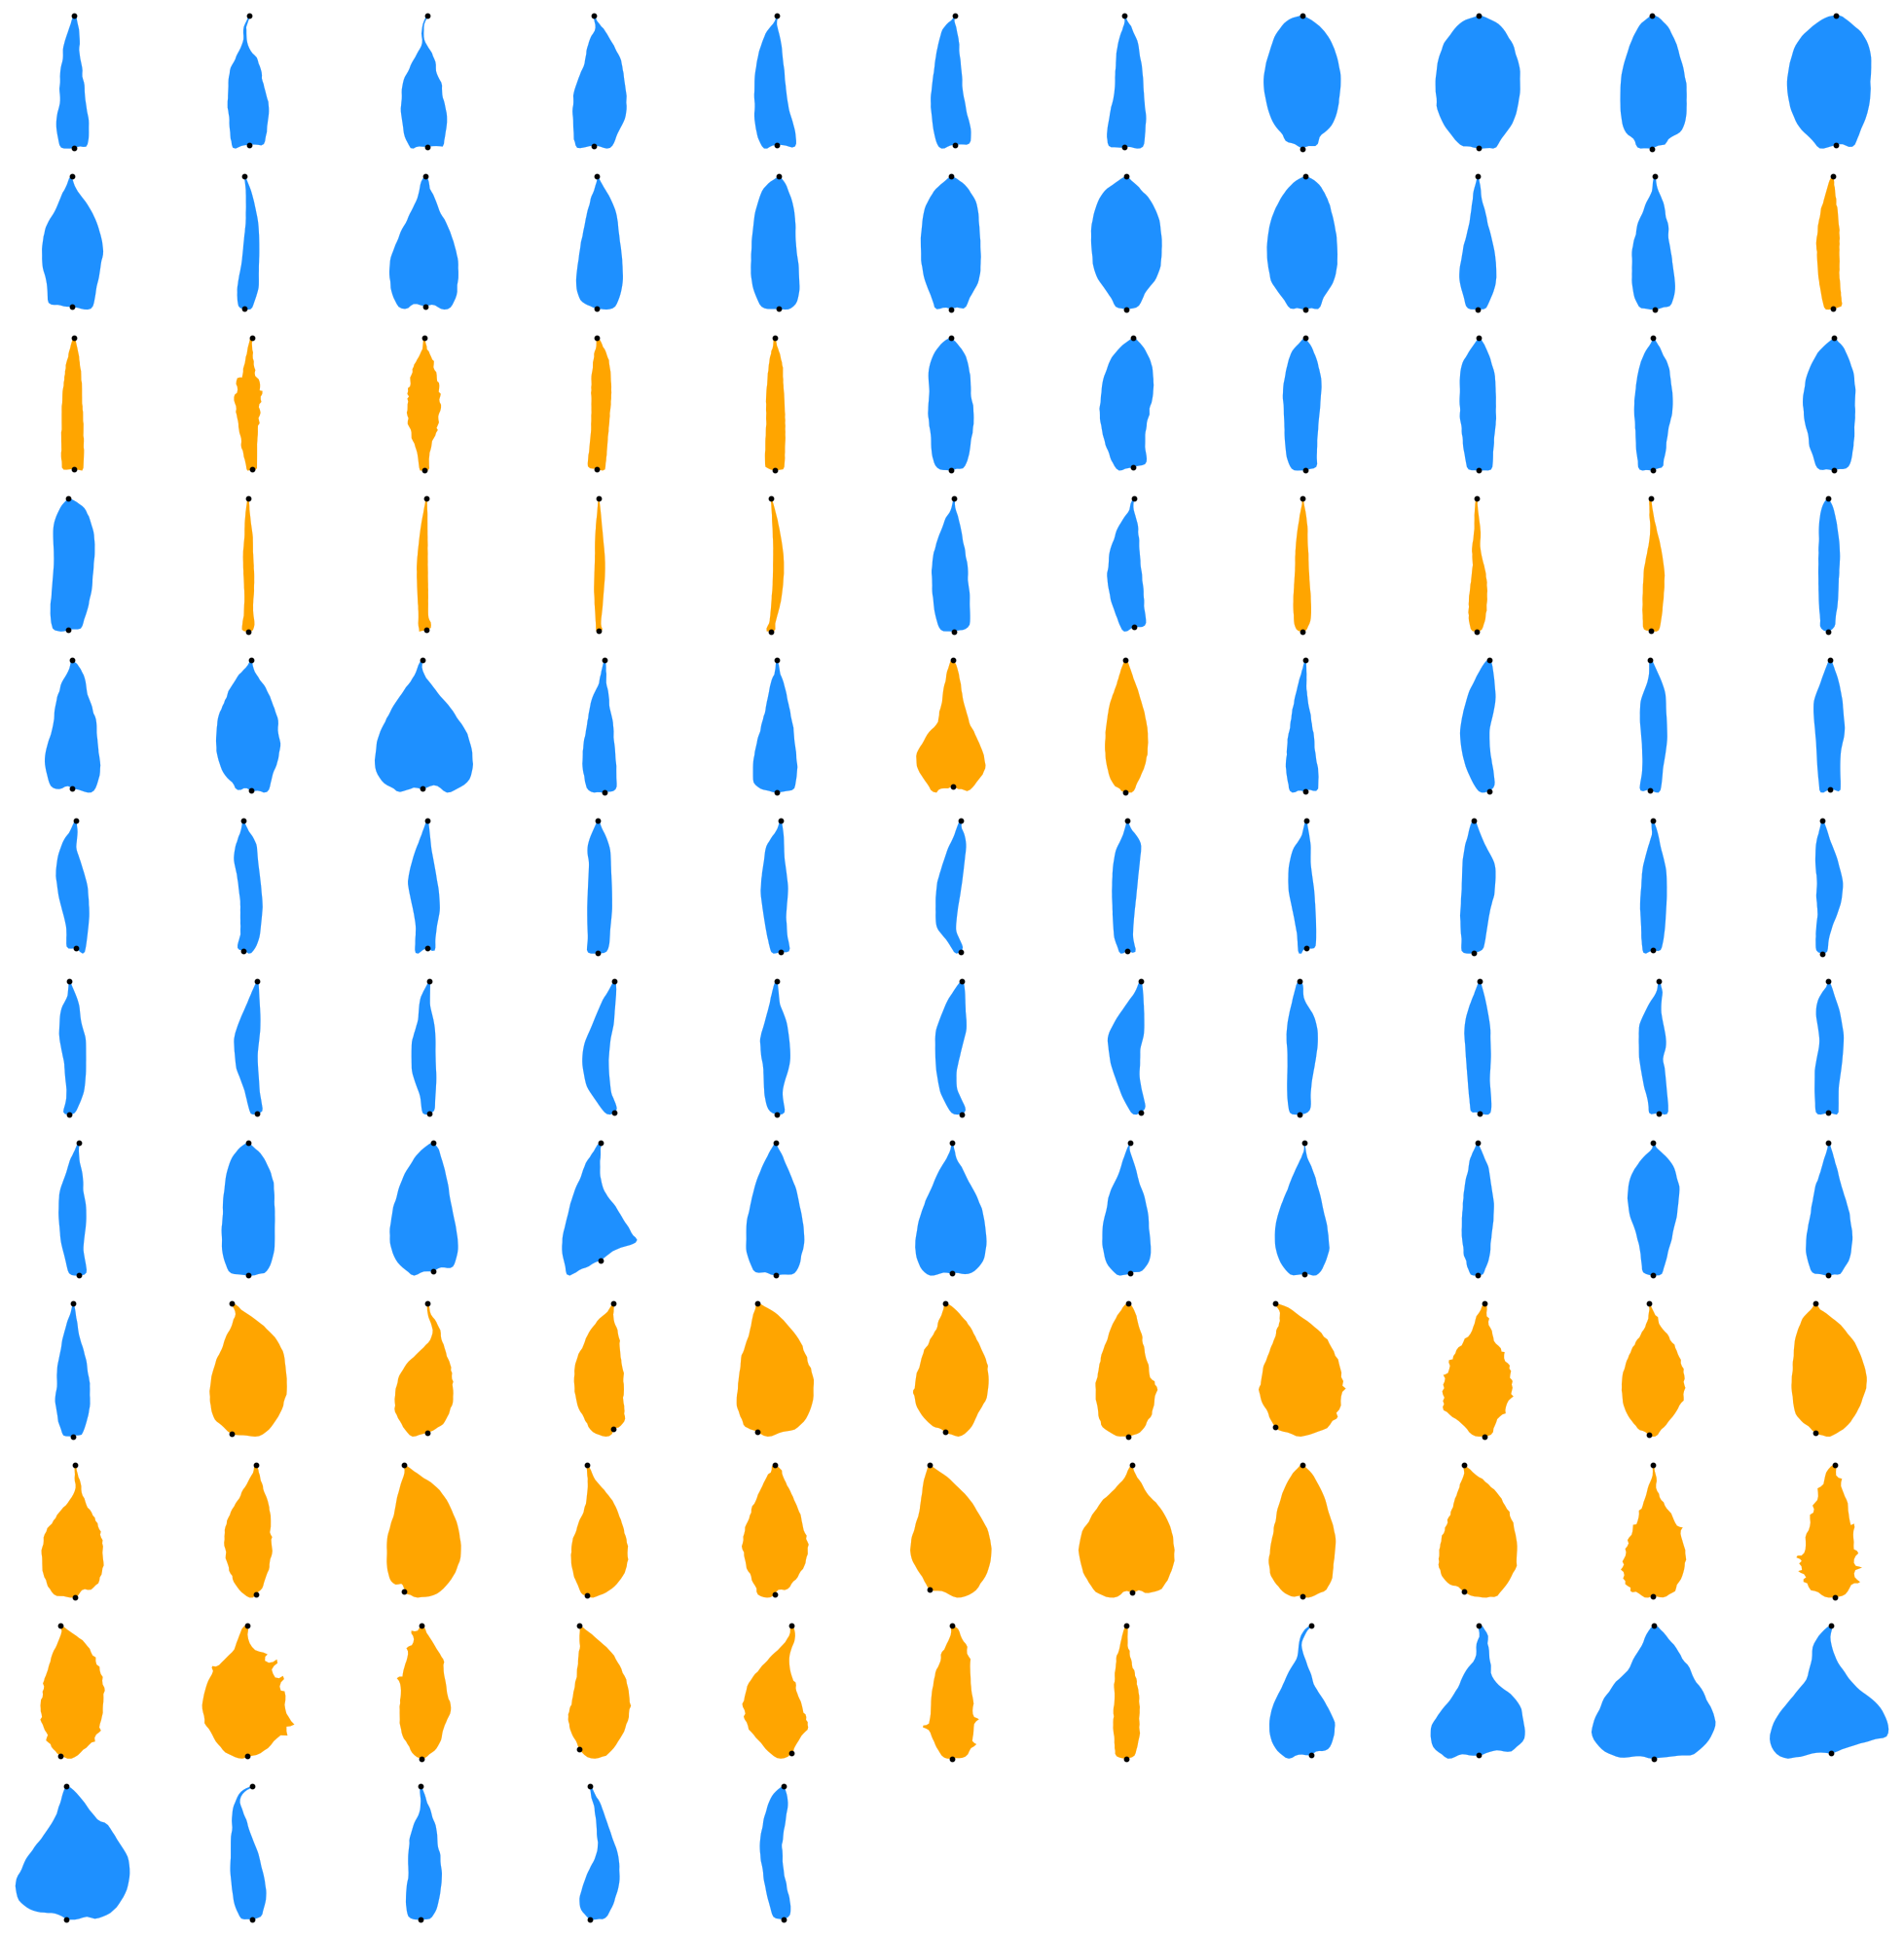

In [6]:
plt.figure(figsize=(20,20)) # set figure size

counter = 1 # set counter for subplot initially to 1

for i in range(len(land_arr)): # for each leaf

    if types[i]=="moss":
        col="dodgerblue"
    elif types[i]=="lycophyte":
        col="orange"
    
    plt.subplot(12,11,counter)
    plt.fill(land_arr[i,:,0], land_arr[i,:,1], c=col, lw=0.1) # outline
    plt.scatter(land_arr[i,0,0], land_arr[i,0,1], s=10, c="k") # base
    plt.scatter(land_arr[i,res-1,0], land_arr[i,res-1,1], s=10, c="k") # tip
    plt.gca().set_aspect("equal")
    plt.gca().set_axis_off()
    counter+=1

plt.tight_layout()

### Analyze leaf dimensions

Using placed pseudo-landmarks representing leaves that are rotated upwards, the following dimensions were calculated: width, as the difference in between minimum and maximum x values in an oriented leaf; length, as the difference between minimum and maximum y values in an oriented leaf; and solidity, the ratio of area to convex area of a leaf.

In [7]:
# lists to store variables
length_to_width_list = []
solidity_list = []

# for each leaf . . .
for lf in range(len(land_arr)):
    
    curr_lf = land_arr[lf,:,:] # select current leaf
    
    ############################
    ### CALCULATE DIMENSIONS ###
    ############################
    
    width = np.max(curr_lf[:,0])-np.min(curr_lf[:,0]) # calculate width
    length = np.max(curr_lf[:,1])-np.min(curr_lf[:,1]) # calculate length
    
    ##########################
    ### CALCULATE SOLIDITY ###
    ##########################
    
    hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
    vertices = hull.vertices # isolate vertex indices of convex hull
    convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
    area = poly_area(curr_lf[:,0], curr_lf[:,1]) # calcualte actual pixel area
    solidity = area / convex_area # calculate solidity
    
    # store data in lists
    length_to_width_list.append(length/width)
    solidity_list.append(solidity)
    

In [8]:
# create a dataframe to store data
# use a dictionary

df = pd.DataFrame({
    "type":types,
    "lw_ratio":length_to_width_list,
    "solid":solidity_list
})

### Pair plots by types

In [9]:
df

,type,lw_ratio,solid
0,moss,4.090732,0.950422
1,moss,3.223859,0.894028
2,moss,2.884464,0.883808
3,moss,2.462002,0.955867
4,moss,3.176323,0.936524
...,...,...,...
121,moss,1.164859,0.960867
122,moss,3.702678,0.817730
123,moss,3.697983,0.954265
124,moss,3.318196,0.767992


<Axes: xlabel='lw_ratio', ylabel='solid'>

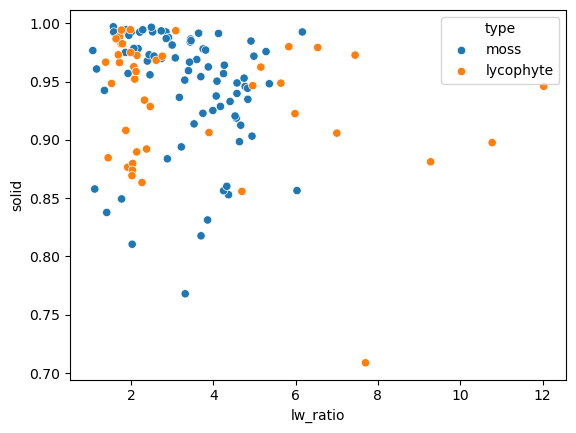

In [10]:
sns.scatterplot(df,
             x="lw_ratio",
             y="solid",
             hue="type"
            )


### Procrustes analysis

Perform a Procrustes analysis to translate, scale, and rotate leaf shapes

- Select number of pseudo-landmarks and dimensions
- Calculate the GPA mean leaf shape using the `gpa_mean` function
- Align all leaves to the GPA mean
- Store Procrustes super-imposed leaves in an array, `proc_arr`
- Calculate a PCA for all possible axes and their variance (the number of leaves)
- Calculate a PCA for just the axes needed for reconstruction of eigenleaves for morphospace (probably 2)

Procrustean alignment was carried out for all leaves together. To superimpose contours by minimizing the overall distance between pseudo-landmark values through the functions of translation, scaling, rotation, and reflection, a generalized Procrustes analysis (GPA) is used ([Gower, 1975](https://link.springer.com/article/10.1007/BF02291478)). A function was defined to calculate a GPA mean. To calculate the GPA mean, an arbitrary leaf is first chosen and all other leaves are aligned to it using Procrustean superimposition. A mean from the aligned shapes is calculated, which is used as the reference shape for alignment in the next iteration. The algorithm stops when the Procrustes distance between means calculated between two successive iterations falls below an arbitrarily low value. All leaves are then aligned to the final GPA mean shape. The Procrustean superimposition was visualized for all leaves by plotting each leaf with high transparency together with overall GPA mean and for each cultivated type and each wild species with respect to group means.

In [11]:
landmark_num = (res*2)-1 # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(land_arr, landmark_num, dim_num)

################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(land_arr)) 

for i in range(len(land_arr)):
    s1, s2, distance = procrustes(mean_shape, land_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

Visualize all leaves plotted against the mean Procrustes leaf

Text(0.5, 1.0, 'overall mean leaf')

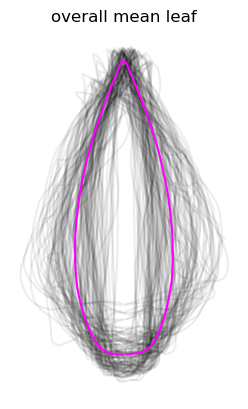

In [12]:
for i in range(len(proc_arr)):
    plt.plot(proc_arr[i,:,0], proc_arr[i,:,1], c="k", alpha=0.07)

plt.plot(np.mean(proc_arr, axis=0)[:,0], np.mean(proc_arr, axis=0)[:,1], c="magenta")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.title("overall mean leaf")

### Morphospace and Linear Discriminant Analysis by type

Visualize a morphospace and classify leaves by the factor of genotype

- Plot a morphospace using the inverse transform of the PCA
- Perform a Linear Discriminant Analysis
- Visualize LDA results as a confusion matrix
- Plot out LDA scores

A morphospace was created and visualized using principal component analysis (PCA) and the inverse PCA transform. To determine the variance associated with each principal component (PC), PCA was first performed with the maximum number of PCs, which in this case is twice the pseudo-landmark number (the number of coordinate values). PCA was fitted again using only 2 PCs for simplicity of morphospace visualization. Along regular intervals of PC1 and PC2 the inverse transform was used to visualize representative leaves, or so-called `eigenleaves`. Data was projected back onto the calcualted PCA and morphospace. A linear discriminant analysis (LDA) model was fitted modeling 198 coordinate values as a function of leaf class. Confusion matrices and LDA scores were calculated by projecting samples back onto the fitted model.

In [13]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = 126 # PC number = number of leaves (less than number of features)
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )


PC: var, overall 
PC1: 70.9%, 70.9%
PC2: 13.1%, 84.0%
PC3: 7.4%, 91.4%
PC4: 2.7%, 94.1%
PC5: 1.5%, 95.6%
PC6: 1.2%, 96.9%
PC7: 0.7%, 97.5%
PC8: 0.5%, 98.0%
PC9: 0.4%, 98.4%
PC10: 0.3%, 98.7%
PC11: 0.2%, 99.0%
PC12: 0.2%, 99.1%
PC13: 0.1%, 99.2%
PC14: 0.1%, 99.3%
PC15: 0.1%, 99.4%
PC16: 0.1%, 99.5%
PC17: 0.1%, 99.6%
PC18: 0.1%, 99.6%
PC19: 0.0%, 99.7%
PC20: 0.0%, 99.7%
PC21: 0.0%, 99.7%
PC22: 0.0%, 99.8%
PC23: 0.0%, 99.8%
PC24: 0.0%, 99.8%
PC25: 0.0%, 99.8%
PC26: 0.0%, 99.8%
PC27: 0.0%, 99.9%
PC28: 0.0%, 99.9%
PC29: 0.0%, 99.9%
PC30: 0.0%, 99.9%
PC31: 0.0%, 99.9%
PC32: 0.0%, 99.9%
PC33: 0.0%, 99.9%
PC34: 0.0%, 99.9%
PC35: 0.0%, 99.9%
PC36: 0.0%, 99.9%
PC37: 0.0%, 99.9%
PC38: 0.0%, 99.9%
PC39: 0.0%, 100.0%
PC40: 0.0%, 100.0%
PC41: 0.0%, 100.0%
PC42: 0.0%, 100.0%
PC43: 0.0%, 100.0%
PC44: 0.0%, 100.0%
PC45: 0.0%, 100.0%
PC46: 0.0%, 100.0%
PC47: 0.0%, 100.0%
PC48: 0.0%, 100.0%
PC49: 0.0%, 100.0%
PC50: 0.0%, 100.0%
PC51: 0.0%, 100.0%
PC52: 0.0%, 100.0%
PC53: 0.0%, 100.0%
PC54: 0.0%, 100.0%
P

In [14]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 2 # keep to 2 for now for reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# add PCs to dataframe for plotting
df["PC1"] = PCs[:,0]
df["PC2"] = PCs[:,1]
    

PC: var, overall 
PC1: 70.9%, 70.9%
PC2: 13.1%, 84.0%


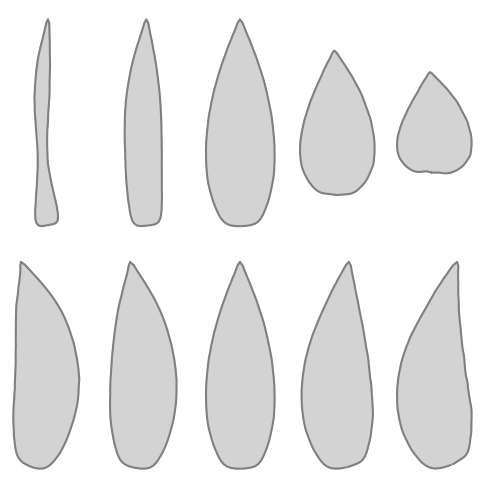

In [15]:
###################################################
### CREATE EIGEN REPRESENTATIONS OF FIRST 2 PCs ###
###################################################

# calculate standard deviations for each PC
PC1_std = df["PC1"].std()
PC2_std = df["PC2"].std()

# create list of lists of PC values to reconstruct
PC_vals = [[-2*PC1_std,0],
           [-1*PC1_std,0],
           [0*PC1_std,0],
           [1*PC1_std,0],
           [2*PC1_std,0],
           [0,-2*PC2_std],
           [0,-1*PC2_std],
           [0,0*PC2_std],
           [0,1*PC2_std],
           [0,2*PC2_std],
]

plt.figure(figsize=(5,5))

counter = 1

for i in range(len(PC_vals)):
    
    # create inverse leaf
    inv_leaf = pca.inverse_transform(np.array(PC_vals[i]))
    inv_x = inv_leaf[0::2] # select just inverse x vals
    inv_y = inv_leaf[1::2] # select just inverse y vals
    
    # plot inverse leaf
    plt.subplot(2,5,counter)
    plt.fill(inv_x, inv_y, c="lightgray")
    plt.plot(inv_x, inv_y, c="gray")
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
    counter += 1

plt.tight_layout()

Text(0.5, 1.0, 'Procrustean morphospace')

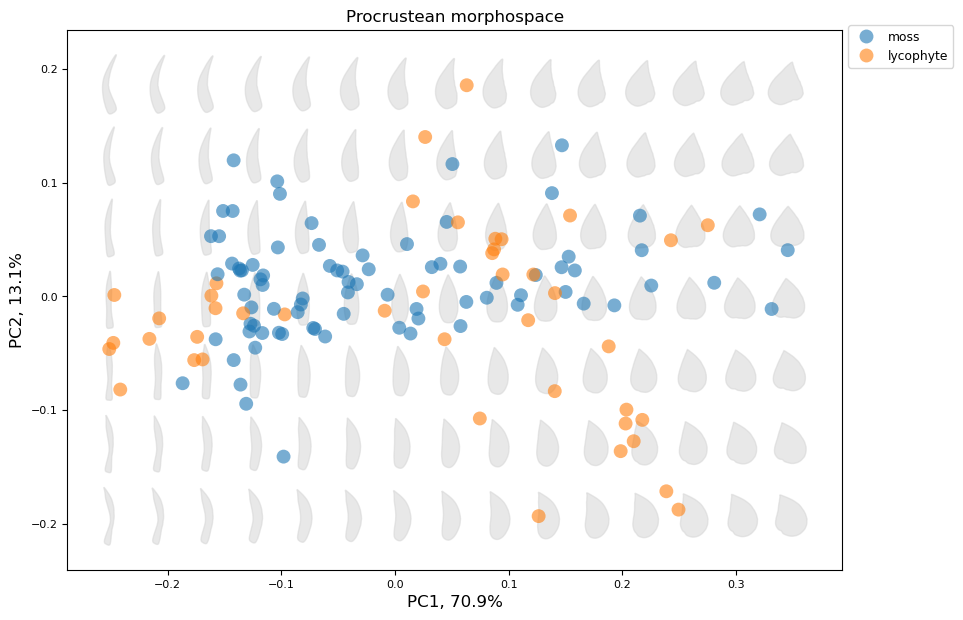

In [16]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPC1 = 15 # set number of PC1 intervals
numPC2 = 7 # set number of PC2 intervals
hue = "type" # select the factor to color by
s = 0.15 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 100 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pc1_val, inv_y*s+pc2_val, c=lf_col, alpha=lf_alpha)
   
# plot the data on top of the morphospace
sns.scatterplot(data=df, x="PC1", y="PC2", hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.gca().set_axisbelow(True)
plt.title(title)

The number of falsely predicted: 0
The number of correctly predicted: 126
Out of 126 total samples


Text(113.9222222222222, 0.5, 'Actual class')

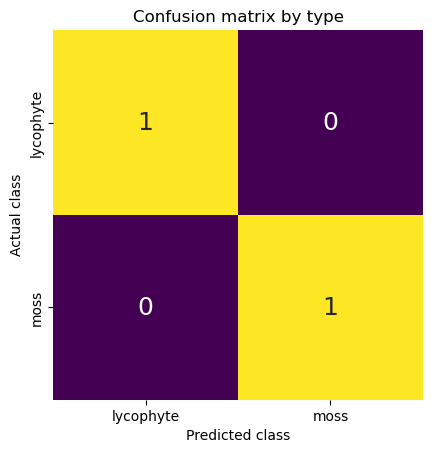

In [17]:
##################################################
### PERFORM LINEAR DISCRIMINANT ANALYSIS (LDA) ###
##################################################

# create a df for LDA by type name
type_df = pd.DataFrame(data=flat_arr[:,:])

# add the type name labels
type_df["type_name"] = df["type"]

# create input and output variables
X = type_df.iloc[:,0:((res*2)-1)*2]
y = type_df["type_name"]

# fit the LDA model
type_model = LinearDiscriminantAnalysis()
type_model.fit(X,y)

# retrieve LDA scalings and coefficients
type_scalings = type_model.scalings_
type_coefs = type_model.coef_

# perform prediction
type_prediction = type_model.predict(X)
comparison_result = [X == y for X, y in zip(y, type_prediction)]

# print out number of correctly predicted results
count_true_pl = comparison_result.count(True)
count_false_pl = comparison_result.count(False)
print("The number of falsely predicted:", count_false_pl)
print("The number of correctly predicted:", count_true_pl)
print("Out of " + str(len(comparison_result)) + " total samples" )

# Create confusion matrix
true_type_values = df["type"]
predicted_type_values = type_prediction

cm_type = confusion_matrix(true_type_values, predicted_type_values, normalize="true")
cm_type = cm_type / cm_type.sum(axis=1)

classes = np.sort(df["type"].unique())

# Confusion matrix

#plt.figure(figsize=(10,10))

sns.heatmap(cm_type, 
            annot=True, 
            annot_kws={"fontsize":18}, 
            #fmt="d", 
            cmap="viridis", 
            square=True, 
            cbar=False,
            xticklabels=classes,
            yticklabels=classes,
            #norm=LogNorm()
           )
plt.title("Confusion matrix by type")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")



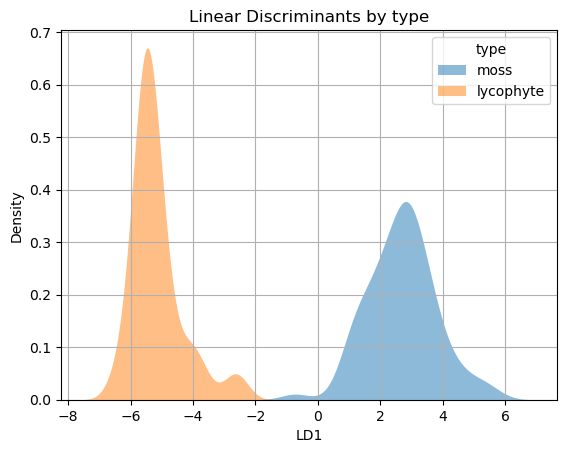

In [18]:
# Plot of linear discriminant scores by type

data_plot = type_model.fit(X, y).transform(X)
type_plot_df = pd.DataFrame(data=data_plot[:,:])
type_plot_df["type"] = df["type"]

type_plot_df = type_plot_df.rename(columns={0:'LD1', 1:'LD2'})

#plt.figure(figsize=(7,7))
#sns.scatterplot(data=type_plot_df, x="LD1", y="LD2", hue="type", s=25, alpha=0.6)
sns.kdeplot(
   data=type_plot_df, x="LD1", hue="type",
   fill=True, common_norm=False, #palette="crest",
   alpha=.5, linewidth=0,
)
#plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})

plt.title("Linear Discriminants by type")
#plt.gca().set_aspect("equal")
plt.grid()